<a href="https://colab.research.google.com/github/LBainWx/MTRSOO/blob/main/ComputePresGradientv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Import Libraries
print("Importing Libraries")
import sys
import os
import numpy as np
import pandas as pd

from datetime import datetime, timedelta
from scipy.ndimage import gaussian_filter
from io import BytesIO
import re


print("Mounting Google Drive")
from google.colab import drive
drive.mount('/content/drive')

print("Finished Importing")

Importing Libraries
Mounting Google Drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Finished Importing


In [ ]:
# @title Enter site1 and site2 (e.g., for a SFO-SAC gradient, enter ksfo and ksac)
site1 = 'khaf'
site2 = 'klvk'

#selected_category = 'IFR'
#hours_before_event = 12  # Define how long to look back before each event

In [ ]:
# @title Fetch and filter data additionally if desired
import pandas as pd

def remove_five_minute_observations(df):
    """
    Removes rows with 5-minute interval observations from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame with a 'date' column containing datetime information.

    Returns:
        pd.DataFrame: Filtered DataFrame without 5-minute interval observations.
    """
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].dt.minute % 5 != 0]
    return df

def get_archived_metars(site):
    """
    Reads archived METAR data for a given site from a CSV file, with optional filtering for 5-minute intervals.

    Args:
        site (str): The site code (e.g., 'ksfo', 'khaf').

    Returns:
        pd.DataFrame: DataFrame containing the METAR data with a datetime index.
    """
    file_path = f"/content/drive/MyDrive/metar_archive/{site}/txt/{site}_archived_data.csv"
    df = pd.read_csv(file_path, low_memory=False)
    df['date'] = pd.to_datetime(df['date'])

    if site.lower() != 'khaf':
        df = remove_five_minute_observations(df)
        print("Removed 5-minute observations")

    return df

def match_and_remove_observations(df1, df2):
    """
    Matches observations between df1 and df2 based on the 'date' column,
    ensuring that each match is only counted once.

    Args:
        df1 (pd.DataFrame): First DataFrame.
        df2 (pd.DataFrame): Second DataFrame.

    Returns:
        pd.DataFrame: DataFrame containing matched observations with suffixes.
    """
    # Perform an inner join on the 'date' column to find matching observations
    df = pd.merge(df1, df2, on='date', suffixes=('_site1', '_site2'))

    # Remove matched observations from both DataFrames
    df1.drop(df.index, inplace=True)
    df2.drop(df.index, inplace=True)

    return df

# Example usage:
df_site1 = get_archived_metars(f'{site1}')
df_site2 = get_archived_metars(f'{site2}')

# Match observations and return the matched DataFrame
df = match_and_remove_observations(df_site1, df_site2)

# Example usage:
df_site1 = get_archived_metars(f'{site1}')
df_site2 = get_archived_metars(f'{site2}')

print(f'Finished data filtering for {site1.upper()}-{site2.upper()} MSLP "gradient" analysis')

Removed 5-minute observations
Removed 5-minute observations
Finished data filtering for KHAF-KLVK MSLP "gradient" analysis


In [ ]:
# @title Compute "Gradients" or MSLP Differences
def compute_mslp_difference(df_site1, df_site2, time_tolerance='10T'):
    """
    Computes the difference in mean sea level pressure (mslp) between two sites,
    ensuring that the observation times are closely matched within a specified time tolerance.

    Args:
        df_site1 (pd.DataFrame): DataFrame containing data for the first site.
        df_site2 (pd.DataFrame): DataFrame containing data for the second site.
        time_tolerance (str): Maximum time difference allowed between observations (e.g., '10T' for 10 minutes).

    Returns:
        pd.DataFrame: DataFrame with matched timestamps, original dates from both sites, and mslp differences.
    """
    # Ensure the 'date' columns are in datetime format
    df_site1['date'] = pd.to_datetime(df_site1['date'])
    df_site2['date'] = pd.to_datetime(df_site2['date'])

    # Rename columns to avoid conflicts during merge
    df_site1 = df_site1.rename(columns={'mslp': 'mslp_site1'})
    df_site2 = df_site2.rename(columns={'mslp': 'mslp_site2'})

    # Drop duplicates in the DataFrames
    df_site1 = df_site1.loc[:, ~df_site1.columns.duplicated()]
    df_site2 = df_site2.loc[:, ~df_site2.columns.duplicated()]

    # Ensure both DataFrames are sorted by the 'date' column
    df_site1.sort_values(by='date', inplace=True)
    df_site2.sort_values(by='date', inplace=True)

    # Use merge_asof to merge DataFrames based on closest match within a given tolerance
    df_merged = pd.merge_asof(
        df_site1,
        df_site2,
        left_on='date',
        right_on='date',
        suffixes=('_site1', '_site2'),
        tolerance=pd.Timedelta(time_tolerance),
        direction='nearest'
    )

    # Compute the difference in mslp
    df_merged['mslp_difference'] = df_merged['mslp_site1'] - df_merged['mslp_site2']

    # Drop rows where there was no match (optional based on your requirement)
    mslp_diff_df = df_merged.dropna(subset=['mslp_difference'])

    return mslp_diff_df

# Example usage:
print(f'Computing {site1.upper()}-{site2.upper()} MSLP "gradients"')
mslp_diff_df = compute_mslp_difference(df_site1, df_site2, time_tolerance='10T')
mslp_diff_df.round({"mslp_site1":2, "mslp_site2":2, "mslp_difference":2})

mslp_diff_df.round({"mslp_site1":2, "mslp_site2":2, "mslp_difference":2})
output_file = f'/content/drive/MyDrive/metar_archive/gradients/txt/all_obs/{site1}_{site2}_gradient_data.csv'
mslp_diff_df.to_csv(output_file, index="False")
print(f'Exporting archived pressure differences based on metar data between {site1.upper()} and {site2.upper()}')

#set aside a dataframe that has all of the observations (no filtering) associated with specific gradients
all_obs = mslp_diff_df

Computing KHAF-KLVK MSLP "gradients"
Exporting archived pressure differences based on metar data between KHAF and KLVK


In [ ]:
# @title Creating events based on ceiling/visibility time and wx code thresholds (New Methodology)

import pandas as pd

# Establish dataframes for various ceilings
lifr_cig = all_obs[all_obs['ceiling_site1'] < 500].copy()
ifr_cig = all_obs[(all_obs['ceiling_site1'] >= 500) & (all_obs['ceiling_site1'] < 1000)].copy()
# cat_e_cig = all_obs[(all_obs['ceiling_site1'] >= 1000) & (all_obs['ceiling_site1'] <= 2000)].copy()
mvfr_cig = all_obs[(all_obs['ceiling_site1'] >= 1000) & (all_obs['ceiling_site1'] <= 3100)].copy()
vfr_sky = all_obs[(all_obs['ceiling_site1'] > 3100) | (all_obs['ceiling_site1'].isna())].copy()

# Establish dataframes for various visibilities
lifr_vis = all_obs[all_obs['visibility_site1'] < 1].copy()
ifr_vis = all_obs[(all_obs['visibility_site1'] >= 1) & (all_obs['visibility_site1'] < 3)].copy()
# cat_e_vis = all_obs[(all_obs['visibility_site1'] >= 0) & (all_obs['visibility_site1'] < 3)].copy()
mvfr_vis = all_obs[(all_obs['visibility_site1'] >= 3) & (all_obs['visibility_site1'] <= 5)].copy()
vfr_vis = all_obs[all_obs['visibility_site1'] > 5].copy()

# Potential caveat—NaN ceiling probably means no ceiling observed, but may mean missing data
# Potential caveat—NaN visibility I think means no visibility observed



# Function to create weather events based on criteria (for ceiling or visibility)
def make_wx_event(df, time_thresh_minutes, min_thresh, max_thresh, exclude_wxcodes, event_type):
    """
    Function to group ceiling or visibility events based on thresholds and weather codes.

    Parameters:
    - df: DataFrame containing ceiling or visibility data.
    - time_thresh_minutes: Minimum duration for grouping events (in minutes).
    - min_thresh: Minimum threshold for events.
    - max_thresh: Maximum threshold for events.
    - exclude_wxcodes: List of weather codes to exclude from events.
    - event_type: 'ceiling' or 'visibility' to determine which data to filter.

    Returns:
    - DataFrame with grouped events.
    """
    # Ensure date is a datetime object
    df.loc[:, 'date'] = pd.to_datetime(df['date'])

    # Filter based on the event type (ceiling or visibility)
    if event_type == 'ceiling_site1':
        df_filtered = df[(df['ceiling_site1'] >= min_thresh) & (df['ceiling_site1'] <= max_thresh)].copy()
    else:  # event_type == 'visibility_site1'
        df_filtered = df[(df['visibility_site1'] >= min_thresh) & (df['visibility_site1'] <= max_thresh)].copy()

    # Exclude specific weather codes
    df_filtered = df_filtered[~df_filtered['wxcode_site1'].isin(exclude_wxcodes)]

    # Group events based on time threshold
    df_filtered.loc[:, 'time_diff'] = df_filtered['date'].diff().dt.total_seconds() / 60
    df_filtered.loc[:, 'group_number'] = (df_filtered['time_diff'] > time_thresh_minutes).cumsum()

    # Calculate the minimum threshold and duration of each event
    if event_type == 'ceiling_site1':
        grouped_events = df_filtered.groupby('group_number').agg({
            'date': ['min', 'max'],
            'ceiling_site1': 'min',
            'mslp_difference': 'mean',
            'visibility_site1': 'mean',
            'sus_wind_site1': 'mean'
        }).reset_index()
        # Flatten MultiIndex columns
        grouped_events.columns = ['group_number', 'start_time', 'end_time', 'min_ceiling', 'mean_mslp_difference', 'mean_visibility', 'mean_wind']

    else:  # event_type == 'visibility_site1'
        grouped_events = df_filtered.groupby('group_number').agg({
            'date': ['min', 'max'],
            'ceiling_site1': 'min',
            'mslp_difference': 'mean',
            'visibility_site1': 'mean',
            'sus_wind_site1': 'mean'
        }).reset_index()
        # Flatten MultiIndex columns
        grouped_events.columns = ['group_number', 'start_time', 'end_time', 'min_ceiling','mean_mslp_difference', 'mean_visibility', 'mean_wind']

    # Calculate event duration
    grouped_events['event_duration'] = grouped_events['end_time'] - grouped_events['start_time']

    return grouped_events

def filter_events_by_duration(df, min_duration_minutes):
    """
    Filters grouped events by a minimum duration.

    Parameters:
    - df: DataFrame containing grouped events.
    - min_duration_minutes: Minimum duration for an event to be included (in minutes).

    Returns:
    - DataFrame with filtered events.
    """
    if df is not None:
        df = df.copy()
        df['event_duration'] = pd.to_timedelta(df['event_duration'])
        min_duration = pd.Timedelta(minutes=min_duration_minutes)
        df = df[df['event_duration'] >= min_duration]
        df['event_duration_minutes'] = df['event_duration'].dt.total_seconds() / 60
        print(f"You now have {len(df)} events exceeding {min_duration_minutes} minutes.")
    else:
        print("Error: df is None")

    return df

# Function to create events for ceiling and visibility separately
def create_events_for_criteria(all_obs, time_thresh_minutes, exclude_wxcodes, min_duration_minutes, criteria, event_type):
    """
    Create events for each flight category separately for ceilings and visibility.

    Parameters:
    - all_obs: DataFrame containing ceiling and visibility data.
    - time_thresh_minutes: Minimum duration for grouping events (in minutes).
    - exclude_wxcodes: List of weather codes to exclude from events.
    - min_duration_minutes: Minimum duration for an event to be included (in minutes).
    - criteria: Dictionary of thresholds (either for ceiling or visibility).
    - event_type: 'ceiling' or 'visibility' to determine which data to filter.

    Returns:
    - Dictionary of DataFrames with events for each flight category.
    """
    criteria_dfs = {}

    for category, thresholds in criteria.items():
        min_thresh = thresholds["min"]
        max_thresh = thresholds["max"]

        print(f"Processing category: {category} ({min_thresh} - {max_thresh})")

        # Create events based on the current thresholds
        df_grouped = make_wx_event(all_obs, time_thresh_minutes, min_thresh, max_thresh, exclude_wxcodes, event_type)

        if df_grouped is not None:
            df_grouped.reset_index(drop=True, inplace=True)
            filtered_events = filter_events_by_duration(df_grouped, min_duration_minutes)
            criteria_dfs[category] = filtered_events
        else:
            print(f"No events found for category {category}")
            criteria_dfs[category] = pd.DataFrame()  # Empty DataFrame for categories with no events

    return criteria_dfs

# Flight categories for ceiling
ceiling_categories = {
    "LIFR": {"min": 0, "max": 499},
    "IFR": {"min": 500, "max": 999},
    "MVFR": {"min": 1000, "max": 3000},
    "CAT_E": {"min": 0, "max": 2000},
    "VFR": {"min": 3001, "max": float('inf')}
}

# Flight categories for visibility
visibility_categories = {
    "LIFR": {"min": 0, "max": 1},          # LifR: Visibility less than 1 mile
    "IFR": {"min": 1, "max": 3},          # IFR: Visibility 1 to 3 miles
    "MVFR": {"min": 3, "max": 5},         # MVFR: Visibility 3 to 5 miles
    "CAT_E": {"min": 0, "max": 3},        # CAT_E: Visibility 0 to 2 miles
    "VFR": {"min": 5.1, "max": float('inf')} # VFR: Visibility greater than 5 miles
}

# Parameters
time_thresh_minutes = 120
exclude_wxcodes = [1, 3, 13, 14, 28, 29, 51, 52]


'''
    1: "Moderate Rain",
    2: "Moderate Drizzle",
    3: "Moderate Snow",
    5: "Thunder",
    6: "Haze",
    7: "Smoke",
    8: "Dust",
    9: "Fog",
    13: "Light Rain",
    14: "Heavy Rain",
    17: "Light Drizzle",
    18: "Heavy Drizzle",
    28: "Light Thunder",
    29: "Heavy Thunder",
    31: "Mist",
    51: "Light Rain Shower",
    52: "Heavy Rain Shower"
'''




min_duration_minutes = 60

# Create separate DataFrames for ceiling events
cig_event_dfs = create_events_for_criteria(all_obs, time_thresh_minutes, exclude_wxcodes, min_duration_minutes, ceiling_categories, event_type='ceiling_site1')

# Create separate DataFrames for visibility events
vis_event_dfs = create_events_for_criteria(all_obs, time_thresh_minutes, exclude_wxcodes, min_duration_minutes, visibility_categories, event_type='visibility_site1')

# Now, you can access each category's events via the dictionaries 'ceiling_event_dfs' and 'visibility_event_dfs'
# Example: To get the IFR ceiling_site1 events, use cig_event_dfs['IFR']
# Example: To get the IFR visibility events, use vis_event_dfs['IFR']


Processing category: LIFR (0 - 499)
You now have 2325 events exceeding 60 minutes.
Processing category: IFR (500 - 999)
You now have 2535 events exceeding 60 minutes.
Processing category: MVFR (1000 - 3000)
You now have 3188 events exceeding 60 minutes.
Processing category: CAT_E (0 - 2000)
You now have 3702 events exceeding 60 minutes.
Processing category: VFR (3001 - inf)
You now have 1451 events exceeding 60 minutes.
Processing category: LIFR (0 - 1)
You now have 977 events exceeding 60 minutes.
Processing category: IFR (1 - 3)
You now have 2858 events exceeding 60 minutes.
Processing category: MVFR (3 - 5)
You now have 4323 events exceeding 60 minutes.
Processing category: CAT_E (0 - 3)
You now have 2965 events exceeding 60 minutes.
Processing category: VFR (5.1 - inf)
You now have 4182 events exceeding 60 minutes.


In [ ]:
# @title Quick Preview of Events

#flight_cat = 'LIFR'
#cig_event_dfs[flight_cat].to_csv(f'/content/drive/MyDrive/metar_archive/gradients/txt/events/{site1.lower()}/{site1.lower()}_event_{flight_cat}_data_for_soundings_v2.csv')
#cig_event_dfs[flight_cat].head()


<ipython-input-9-ad02bc2c48cf>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='month', y='mslp_difference', data=mean_mslp_per_event_during, palette='viridis', showmeans=True, meanline=True)


Saved Figure
Saved Onset/Ending Observation for khaf and klvk


<Figure size 640x480 with 0 Axes>

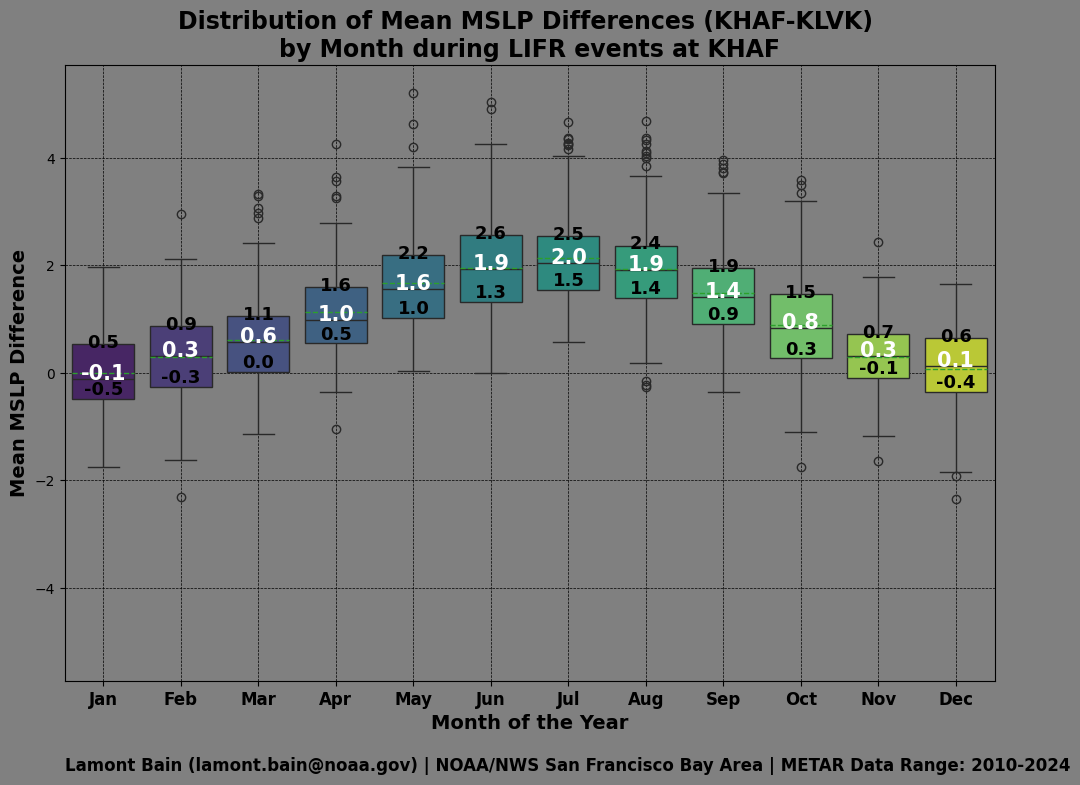

In [ ]:
# @title Examining observations DURING a ceiling event (Box and Whisker)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

selected_category = 'LIFR'

def create_during_event_obs(mslp_diff_df, events_df):
    """
    Creates a DataFrame of observations from mslp_diff_df that occur during each event.

    Parameters:
    - mslp_diff_df: DataFrame containing MSLP difference data.
    - events_df: DataFrame containing grouped events.

    Returns:
    - during_event_obs: DataFrame with observations during each event, including a 'group_number' column.
    """
    # Convert 'date' column to datetime
    mslp_diff_df['date'] = pd.to_datetime(mslp_diff_df['date'])

    # Create an empty DataFrame to store results
    during_event_obs = pd.DataFrame()

    # Iterate over each event and assign a group number
    for group_number, (_, event) in enumerate(events_df.iterrows(), start=1):
        start_time = event['start_time']
        end_time = event['end_time']

        # Filter mslp_diff_df for observations during the event
        event_obs = mslp_diff_df[(mslp_diff_df['date'] >= start_time) & (mslp_diff_df['date'] < end_time)].copy()

        # Assign the group number to each observation using .loc
        event_obs.loc[:, 'event_id'] = group_number

        # Append to the results DataFrame
        during_event_obs = pd.concat([during_event_obs, event_obs], ignore_index=True)

    return during_event_obs

# Ensure 'date' is in datetime format in mslp_diff_df
mslp_diff_df['date'] = pd.to_datetime(mslp_diff_df['date'])

# Create during_event_obs DataFrame for ceiling events
during_event_obs = create_during_event_obs(mslp_diff_df, cig_event_dfs[selected_category])

# Ensure 'date' is in datetime format
during_event_obs['date'] = pd.to_datetime(during_event_obs['date'])

# Calculate mean MSLP difference for each event
mean_mslp_per_event_during = during_event_obs.groupby('event_id').agg({'mslp_difference': 'mean', 'date': 'first'}).reset_index()

# Extract month from the date of each event
mean_mslp_per_event_during['month'] = mean_mslp_per_event_during['date'].dt.month

# Get start and end years
data_start = during_event_obs['date'].dt.year.min()
data_end = during_event_obs['date'].dt.year.max()

# Set up the figure and axis
plt.clf()
plt.figure(figsize=(12, 8), facecolor='grey')

# Set the background color of the plot area to grey
ax = plt.gca()  # Get current axis
ax.set_facecolor('grey')  # Set the plot area background to grey

# Create the box plot grouped by month
sns.boxplot(x='month', y='mslp_difference', data=mean_mslp_per_event_during, palette='viridis', showmeans=True, meanline=True)

# Calculate and label quartiles for each month
for month in range(1, 13):
    month_data = mean_mslp_per_event_during[mean_mslp_per_event_during['month'] == month]['mslp_difference']
    if not month_data.empty:
        lower_quartile, median, upper_quartile = np.percentile(month_data, [25, 50, 75])
        plt.text(month-1, lower_quartile, f'{lower_quartile:.1f}', color='black', ha='center', va='bottom', fontsize=13, fontweight='bold')
        plt.text(month-1, median+0.1, f'{median:.1f}', color='white', ha='center', va='center', fontsize=15, fontweight='bold')
        plt.text(month-1, upper_quartile+0.2, f'{upper_quartile:.1f}', color='black', ha='center', va='top', fontsize=13, fontweight='bold')

# Set the title and labels
plt.title(f'Distribution of Mean MSLP Differences ({site1.upper()}-{site2.upper()}) \nby Month during {selected_category} events at {site1.upper()}',
          fontsize=17, fontweight='bold')

# Calculate the true range of the data
data_min = mean_mslp_per_event_during['mslp_difference'].min()
data_max = mean_mslp_per_event_during['mslp_difference'].max()

# Determine the maximum absolute value between min and max for symmetry
max_abs_value = max(abs(data_min), abs(data_max))

# Add a buffer of 10% to the range to ensure there's some space around the extremes
buffer = max_abs_value * 0.1

# Set the ylim to be symmetric with the buffer
plt.ylim(-max_abs_value - buffer, max_abs_value + buffer)



plt.xlabel('Month of the Year', fontsize=14, fontweight='bold')
plt.ylabel('Mean MSLP Difference', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12, fontweight='bold')

# Add grid with dashed lines
plt.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')

# Add grid with dashed lines
plt.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')

#Add my signature

plt.annotate(f'\nLamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area | METAR Data Range: {data_start}-{data_end}', (0,0), (0, -40)
          , fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top', fontweight='bold')


save_path = f'/content/drive/MyDrive/metar_archive/gradients/img/'
save_filename = f'{save_path}{site1}_{site2}_monthly_mslp_diff_{selected_category}_all_events_bw.png'
print("Saved Figure")
plt.savefig(save_filename)
print(f'Saved Onset/Ending Observation for {site1} and {site2}')

plt.show()




Finished retrieving observations during the selected category events at KHAF. There are a total of 19582 observations.


<ipython-input-8-48a078f4c4c8>:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='month', y='mslp_difference', data=mean_mslp_per_event_during, inner='quartile', palette='viridis')


Saved Figure
Saved Onset/Ending Observation for khaf and ksfo


<Figure size 640x480 with 0 Axes>

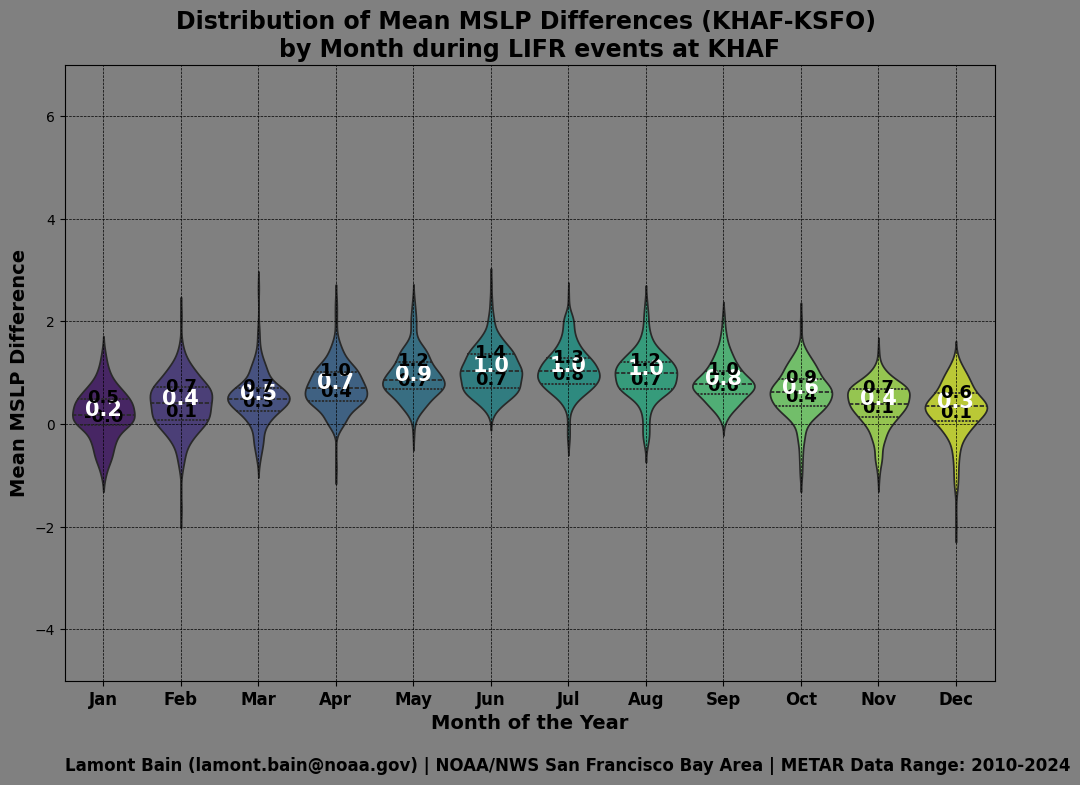

In [ ]:
# @title Examining observations DURING a ceiling event
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

selected_category = 'LIFR'

def create_during_event_obs(mslp_diff_df, events_df):
    """
    Creates a DataFrame of observations from mslp_diff_df that occur during each event.

    Parameters:
    - mslp_diff_df: DataFrame containing MSLP difference data.
    - events_df: DataFrame containing grouped events.

    Returns:
    - during_event_obs: DataFrame with observations during each event, including a 'group_number' column.
    """
    # Convert 'date' column to datetime
    mslp_diff_df['date'] = pd.to_datetime(mslp_diff_df['date'])

    # Create an empty DataFrame to store results
    during_event_obs = pd.DataFrame()

    # Iterate over each event and assign a group number
    for group_number, (_, event) in enumerate(events_df.iterrows(), start=1):
        start_time = event['start_time']
        end_time = event['end_time']

        # Filter mslp_diff_df for observations during the event
        event_obs = mslp_diff_df[(mslp_diff_df['date'] >= start_time) & (mslp_diff_df['date'] < end_time)].copy()

        # Assign the group number to each observation using .loc
        event_obs.loc[:, 'event_id'] = group_number

        # Append to the results DataFrame
        during_event_obs = pd.concat([during_event_obs, event_obs], ignore_index=True)

    return during_event_obs

# Ensure 'date' is in datetime format in mslp_diff_df
mslp_diff_df['date'] = pd.to_datetime(mslp_diff_df['date'])

# Create during_event_obs DataFrame


# Replace the appropriate DataFrame based on whether you want to analyze ceiling or visibility events
# For ceiling events:
during_event_obs = create_during_event_obs(mslp_diff_df, cig_event_dfs[selected_category])

# For visibility events:
# during_event_obs = create_during_event_obs(mslp_diff_df, vis_event_dfs[selected_category])

print(f"Finished retrieving observations during the selected category events at {site1.upper()}. There are a total of {len(during_event_obs)} observations.")


# Ensure 'date' is in datetime format
during_event_obs['date'] = pd.to_datetime(during_event_obs['date'])

# Calculate mean MSLP difference for each event
mean_mslp_per_event_during = during_event_obs.groupby('event_id').agg({'mslp_difference': 'mean', 'date': 'first'}).reset_index()

# Extract month from the date of each event
mean_mslp_per_event_during['month'] = mean_mslp_per_event_during['date'].dt.month


#Get start and end years
data_start = (during_event_obs['date'].dt.year.min())
data_end = (during_event_obs['date'].dt.year.max())


# Set up the figure and axis
plt.clf()
plt.figure(figsize=(12, 8), facecolor='grey')

# Set the background color of the plot area to grey
ax = plt.gca()  # Get current axis
ax.set_facecolor('grey')  # Set the plot area background to grey

# Create the violin plot grouped by month
sns.violinplot(x='month', y='mslp_difference', data=mean_mslp_per_event_during, inner='quartile', palette='viridis')

# Calculate and label quartiles for each month
for month in range(1, 13):
    month_data = mean_mslp_per_event_during[mean_mslp_per_event_during['month'] == month]['mslp_difference']
    if not month_data.empty:
        lower_quartile, median, upper_quartile = np.percentile(month_data, [25, 50, 75])
        plt.text(month-1, lower_quartile, f'{lower_quartile:.1f}', color='black', ha='center', va='bottom', fontsize=13, fontweight='bold')
        plt.text(month-1, median+0.1, f'{median:.1f}', color='white', ha='center', va='center', fontsize=15, fontweight='bold')
        plt.text(month-1, upper_quartile+0.2, f'{upper_quartile:.1f}', color='black', ha='center', va='top', fontsize=13, fontweight='bold')

# Set the title and labels
plt.title(f'Distribution of Mean MSLP Differences ({site1.upper()}-{site2.upper()}) \nby Month during {selected_category} events at {site1.upper()}',
          fontsize=17, fontweight='bold')
plt.ylim(-5,7)
plt.xlabel('Month of the Year', fontsize=14, fontweight='bold')
plt.ylabel('Mean MSLP Difference', fontsize=14, fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12, fontweight='bold')

# Add grid with dashed lines
plt.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')

#Add my signature

plt.annotate(f'\nLamont Bain (lamont.bain@noaa.gov) | NOAA/NWS San Francisco Bay Area | METAR Data Range: {data_start}-{data_end}', (0,0), (0, -40)
          , fontsize=12, xycoords='axes fraction', textcoords='offset points', va='top', fontweight='bold')


save_path = f'/content/drive/MyDrive/metar_archive/gradients/img/'
save_filename = f'{save_path}{site1}_{site2}_monthly_mslp_diff_{selected_category}_all_events_violinplot.png'
print("Saved Figure")
plt.savefig(save_filename)
print(f'Saved Onset/Ending Observation for {site1} and {site2}')

plt.show()

Saved Onset/Ending Observation for khaf and ksfo


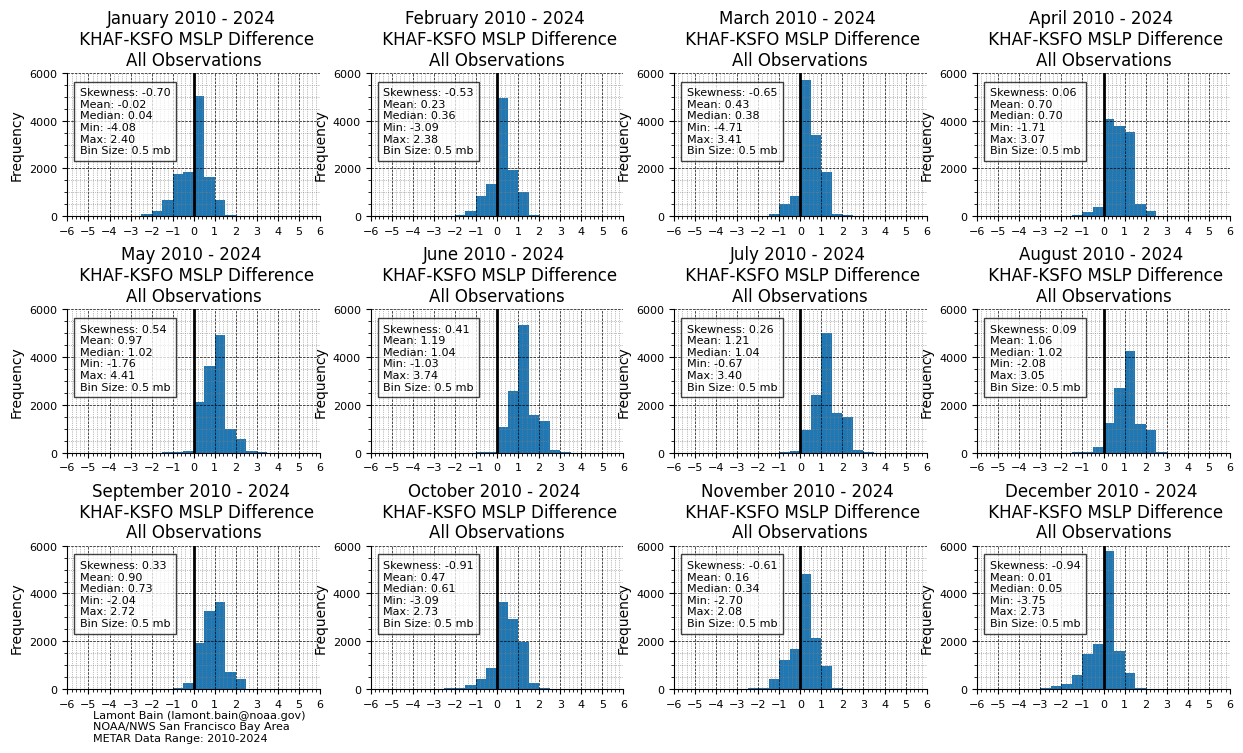

In [ ]:
#@title Histogram for all MSLP gradient/differences between sites1 and sites2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

# Assuming mslp_diff_df is already in memory
# Ensure 'date_site1' is in datetime format
mslp_diff_df['date_site1'] = pd.to_datetime(mslp_diff_df['date'])

# Extract the month from 'date_site1'
mslp_diff_df['month'] = mslp_diff_df['date'].dt.month

# Define month names for labeling
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Get the start and end year of the dataset
obs_start = mslp_diff_df['date_site1'].dt.year.min()
obs_end = mslp_diff_df['date_site1'].dt.year.max()



# Define the bin width
bin_width = 0.5

# Define global x-axis limits
xmin = -6
xmax = abs(xmin)
ymin = 0
ymax = 6001

# Define the bin width
bin_width = 0.5

# Define x-axis ticks based on the limits
x_ticks = np.arange(xmin, xmax + 1, 1.)

# Set up a 3x4 grid for the histograms
fig, axes = plt.subplots(3, 4, figsize=(15, 8))  # 3 rows, 4 columns
# Adjust the space between subplots
plt.subplots_adjust(hspace=0.65)

# Define month names for labeling
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Get the start and end year of the dataset
obs_start = mslp_diff_df['date_site1'].dt.year.min()
obs_end = mslp_diff_df['date_site1'].dt.year.max()

# Loop through each month (1-12)
for i in range(1, 13):
    # Filter the data for the current month
    monthly_data = mslp_diff_df[mslp_diff_df['month'] == i]['mslp_difference']

    # Compute skewness
    monthly_skewness = skew(monthly_data.dropna())  # Drop NaN values before computing skewness

    # Calculate statistical values
    monthly_mean = monthly_data.mean()
    monthly_median = monthly_data.median()
    monthly_min = monthly_data.min()
    monthly_max = monthly_data.max()

    # Determine the bin edges
    bin_edges = np.arange(xmin, xmax + bin_width, bin_width)

    # Plot the histogram in the corresponding subplot
    ax = axes[(i-1)//4, (i-1)%4]  # Calculate row and column index
    monthly_data.plot(kind='hist', bins=bin_edges, ax=ax, title=f'{month_names[i-1]} {obs_start} - {obs_end} \n {site1.upper()}-{site2.upper()} MSLP Difference\nAll Observations', fontsize=9)

    # Add statistical information as text at the top of the plot
    stats_text = (
        f'Skewness: {monthly_skewness:.2f}\n'
        f'Mean: {monthly_mean:.2f}\n'
        f'Median: {monthly_median:.2f}\n'
        f'Min: {monthly_min:.2f}\n'
        f'Max: {monthly_max:.2f}\n'
        f'Bin Size: {bin_width} mb'
    )
    ax.text(0.05, 0.90, stats_text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.75))

    # Customize the subplot
    ax.spines[['top', 'right']].set_visible(False)
    ax.yaxis.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
    ax.xaxis.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')

    # Enable minor grid lines
    ax.minorticks_on()  # Enable minor ticks
    ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')  # Minor y-axis grid lines
    ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')  # Minor x-axis grid lines

    # Set global x-axis limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Set x-axis and y-axis ticks
    ax.set_xticks(x_ticks)
    #ax.set_yticks(np.arange(ymin, ymax + 25, 25))

    # Add a thick black line at 0mb pressure difference
    ax.axvline(0, color='black', linewidth=2)

    # Set tick parameters
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)


#Add annotation
plt.annotate(f'Lamont Bain (lamont.bain@noaa.gov) \nNOAA/NWS San Francisco Bay Area \nMETAR Data Range: {data_start}-{data_end}', (-3.5,0), (0, -15)
          , fontsize=8, xycoords='axes fraction', textcoords='offset points', va='top')

# Adjust layout to prevent overlapping labels
#plt.tight_layout()

save_path = f'/content/drive/MyDrive/metar_archive/gradients/img/'
save_filename = f'{save_path}{site1}_{site2}_mslp_diff_jan_dec_{selected_category}_allmslpdiff_histograms.png' #All Data
plt.savefig(save_filename)
print(f'Saved Onset/Ending Observation for {site1} and {site2}')


# Show the plot
plt.show()

Saved Onset/Ending Observation for khaf and ksfo


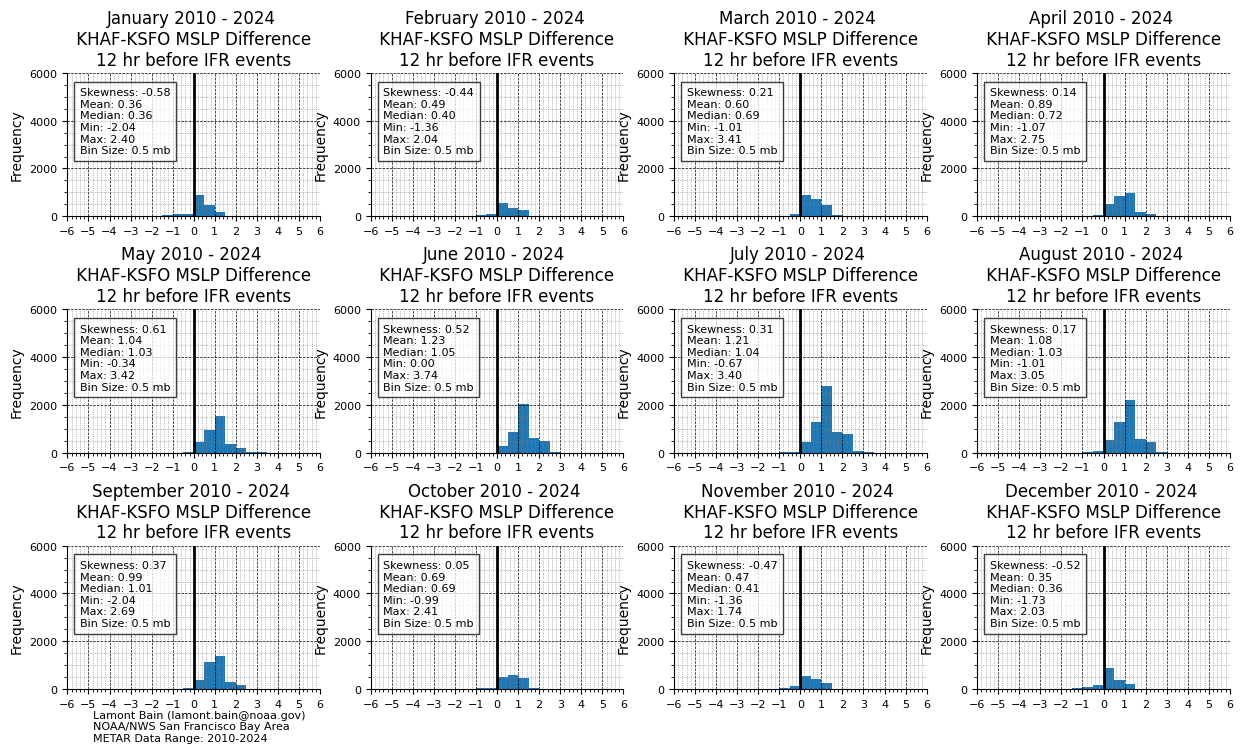

In [ ]:
#@title Histogram BEFORE specificed category events MSLP gradient/differences between sites1 and sites2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew

# Assuming pre_event_obs is already in memory
# Ensure 'date' is in datetime format
pre_event_obs['date'] = pd.to_datetime(pre_event_obs['date'])

# Extract the month from 'date'
pre_event_obs['month'] = pre_event_obs['date'].dt.month

# Define month names for labeling
month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Get the start and end year of the dataset
obs_start = pre_event_obs['date'].dt.year.min()
obs_end = pre_event_obs['date'].dt.year.max()

# Define the bin width
bin_width = 0.5

# Define global x-axis limits
xmin = -6
xmax = abs(xmin)
ymin = 0
ymax = 6001

# Define x-axis ticks based on the limits
x_ticks = np.arange(xmin, xmax + 1, 1.)

# Set up a 3x4 grid for the histograms
fig, axes = plt.subplots(3, 4, figsize=(15, 8))  # 3 rows, 4 columns
# Adjust the space between subplots
plt.subplots_adjust(hspace=0.65)

# Loop through each month (1-12)
for i in range(1, 13):
    # Filter the data for the current month
    monthly_data = pre_event_obs[pre_event_obs['month'] == i]['mslp_difference']

    # Compute skewness
    monthly_skewness = skew(monthly_data.dropna())  # Drop NaN values before computing skewness

    # Calculate statistical values
    monthly_mean = monthly_data.mean()
    monthly_median = monthly_data.median()
    monthly_min = monthly_data.min()
    monthly_max = monthly_data.max()

    # Determine the bin edges
    bin_edges = np.arange(xmin, xmax + bin_width, bin_width)

    # Plot the histogram in the corresponding subplot
    ax = axes[(i-1)//4, (i-1)%4]  # Calculate row and column index
    monthly_data.plot(kind='hist', bins=bin_edges, ax=ax, title=f'{month_names[i-1]} {obs_start} - {obs_end} \n {site1.upper()}-{site2.upper()} MSLP Difference \n{hours_before_event} hr before {selected_category} events', fontsize=9)

    # Add statistical information as text at the top of the plot
    stats_text = (
        f'Skewness: {monthly_skewness:.2f}\n'
        f'Mean: {monthly_mean:.2f}\n'
        f'Median: {monthly_median:.2f}\n'
        f'Min: {monthly_min:.2f}\n'
        f'Max: {monthly_max:.2f}\n'
        f'Bin Size: {bin_width} mb'
    )
    ax.text(0.05, 0.90, stats_text, transform=ax.transAxes, fontsize=8,
            verticalalignment='top', horizontalalignment='left',
            bbox=dict(facecolor='white', alpha=0.75))

    # Customize the subplot
    ax.spines[['top', 'right']].set_visible(False)
    ax.yaxis.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')
    ax.xaxis.grid(True, linestyle='dashed', which='both', linewidth=0.5, color='black')

    # Enable minor grid lines
    ax.minorticks_on()  # Enable minor ticks
    ax.yaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')  # Minor y-axis grid lines
    ax.xaxis.grid(True, which='minor', linestyle=':', linewidth=0.5, color='gray')  # Minor x-axis grid lines

    # Set global x-axis limits
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Set x-axis and y-axis ticks
    ax.set_xticks(x_ticks)
    #ax.set_yticks(np.arange(ymin, ymax + 25, 25))


    # Add a thick black line at 0mb pressure difference
    ax.axvline(0, color='black', linewidth=2)

    # Set tick parameters
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)


#Add annotation
plt.annotate(f'Lamont Bain (lamont.bain@noaa.gov) \nNOAA/NWS San Francisco Bay Area \nMETAR Data Range: {data_start}-{data_end}', (-3.5,0), (0, -15)
          , fontsize=8, xycoords='axes fraction', textcoords='offset points', va='top')


save_path = f'/content/drive/MyDrive/metar_archive/gradients/img/'
save_filename = f'{save_path}{site1}_{site2}_mslp_diff_jan_dec_{selected_category}_{hours_before_event}_pre_event_histograms.png' #All Data
plt.savefig(save_filename)
print(f'Saved Onset/Ending Observation for {site1} and {site2}')

# Show the plot
plt.show()
